# Using Multioutput Regression

### Reasoning

If the DR data can reproduce the original data set, that suggests that most of the variance in the original data is held within the reduced data. 

### Method

The ligands were split into a test and training set (X% and Y%). The training set is used to build a model of the descriptors for the test set. The accuracy with which these descriptors are predicted is used as a measure of the information retained. One can use multi-output regression methods (https://wires.onlinelibrary.wiley.com/doi/10.1002/widm.1157). 

### Code

In [1]:
# Import data and modules
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge

LKB = pd.read_excel (r'DR_Comparison.xlsx',  sheet_name='LKBPP screen dataset')

descriptors = ['homo', 'lumo', 'pa', 'homo2', 'lumo2', 'pa2', 'he.w.pn', 'nhe', 'be.gla', 'ml.gla', 'dmd.gla', 'd.d1rgla', 'd.d2rgla', 'drd1rgla', 
               'drd2rgla', 'nbo.glaf', 'be.pd', 'ml.pd', 'dmd.pd', 'd.d1r.pd', 'd.d2r.pd', 'd.rd1rpd', 'd.rd2rpd', 'nbo.pd.f', 'dppd.d1', 'dppd.d2', 
               'dpzn.d1', 'dpzn.d2']

C:\Users\rn22569\.conda\envs\book-env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Scale the data
scaler = StandardScaler()
data_std = scaler.fit_transform(LKB[descriptors])

In [3]:
#Definition of each dimensionality reduction technique
pca = PCA(n_components=7).fit_transform(data_std)
pca_df_scale = pd.DataFrame(pca, columns=['PC1', 'PC2', 'PC3','PC4', 'PC5', 'PC6', 'PC7'])

tsne = TSNE(n_components=10, verbose=0, perplexity=12, n_iter=5000, learning_rate="auto", 
            method='exact', random_state=42).fit_transform(data_std)
tsne_df_scale = pd.DataFrame(tsne, columns=['tsne1', 'tsne2', 'tsne3','tsne4', 'tsne5', 'tsne6', 'tsne7', 
                                            'tsne8', 'tsne9', 'tsne10'])

umap_15 = umap.UMAP(n_neighbors=15,min_dist=0.5,n_components=10,random_state=42).fit_transform(data_std)
umap_df_scale_15 = pd.DataFrame(umap_15, columns=['umap1', 'umap2', 'umap3', 'umap4', 'umap5', 'umap6', 'umap7', 
                                                  'umap8', 'umap9', 'umap10'])

C:\Users\rn22569\.conda\envs\book-env\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


In [4]:
#Set a radom state:
n=6

In [5]:
# 
y=data_std
y_df = pd.DataFrame.from_records(data_std, columns=LKB[descriptors].columns, index=LKB[descriptors].index)

In [6]:
def get_summary(x_set, max_error):
    """ 
    Take a training set of X, make predictions, and give results
    x_set is a set of dimentionality reduced data
    max_error is a float between 0 and 1, i.e. 0.2 = 20% deviation
    """
            
    X=x_set
    x_train,x_test,y_train,y_test=train_test_split(X,y_df,test_size=0.2,random_state=n)

    regr = MultiOutputRegressor(Ridge(random_state=123)).fit(x_train.to_numpy(), y_train.to_numpy())
    y_pred = regr.predict(x_test.to_numpy())
    y_pred_df = pd.DataFrame.from_records(y_pred, columns=y_test.columns, index=y_test.index)
    residuals = y_test-y_pred_df

    
    R2=r2_score(y_test,y_pred, multioutput='raw_values')
    R2 = pd.Series(R2, index=y_test.columns)
    R2_frame = R2.to_frame(name="R2").transpose()

    ranges=y_test.max() - y_test.min()

    # Bring these all onto the same scale to compare them
    abs_resid = residuals / ranges
    
    count_over = abs_resid[abs_resid > max_error ].count().sum()

    plt.figure(figsize=(9, 3))
    sns.heatmap(abs(abs_resid), annot=False, cmap=sns.cm.rocket)

    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    description_df = abs_resid.describe()
    #description_df.append(pd.Series(R2),ignore_index=True)
    description_df_ = pd.concat([description_df, R2_frame], axis=0, sort=True)

    max_cols = description_df.apply(lambda s, n: s.nlargest(n).index, axis=1, n=5)['max']
    description_df[max_cols] 
    
    soloR2 = r2_score(y_test,y_pred)
    mean_dev = abs(abs_resid).mean().mean()
    max_dev = abs(abs_resid).max().max()
    for_table = [soloR2, mean_dev, max_dev]
    
    return description_df_, count_over, max_cols, for_table, R2, abs_resid

### PCA

95


[0.8936488765886487, 0.05182575769492048, 0.5331408261371625]

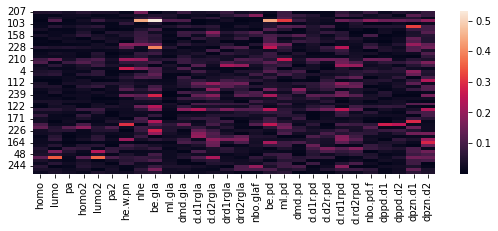

In [7]:
description_df_pca, count_over_pca, max_cols_pca,for_table, R2_pca, abs_resid_pca = get_summary(pca_df_scale, 0.1)
print(count_over_pca)
description_df_pca[max_cols_pca]

for_table

### UMAP

217


0.7256203579242123

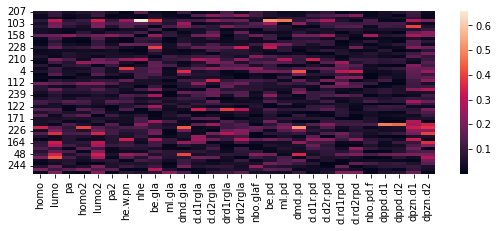

In [8]:
description_df_umap15, count_over_umap15, max_cols_umap15,for_table, R2_umap, abs_resid_umap = get_summary(umap_df_scale_15, 0.1)
print(count_over_umap15)
description_df_umap15[max_cols_umap15]

for_table[0]

### t-SNE

382


0.44738516787299437

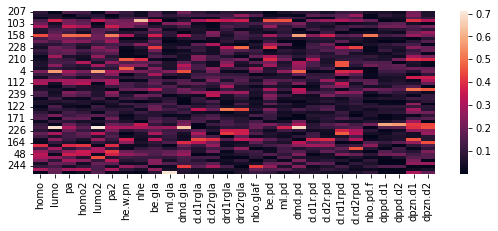

In [9]:
description_df_tsne, count_over_tsne, max_cols_tsne,for_table, R2_tsne, abs_resid_tsne = get_summary(tsne_df_scale, 0.1)
print(count_over_tsne)
description_df_tsne[max_cols_tsne]

for_table[0]

### All together

In [10]:
def plot_attribute(atr):
    """ Choose to plot one of count, mean, std, min, 25%, 50%, 75%, max, R2"""
    
    # Make df
    
    df_atr = pd.DataFrame()
    df_atr['PCA'] = description_df_pca.loc[atr]
    df_atr['UMAP_15'] = description_df_umap15.loc[atr]
    df_atr['t-SNE'] = description_df_tsne.loc[atr]
    
    # plot
    ax = df_atr.plot(figsize=(12, 4))
    ax.set_ylabel(atr + ' of Regression', fontsize=12)
    ax.set_xlabel('Descriptor', fontsize=12)

    ax.set_xticks(np.arange(len(descriptors)))
    ax.set_xticklabels(descriptors)
    plt.xticks(rotation=60)

    plt.show()
    
    return df_atr

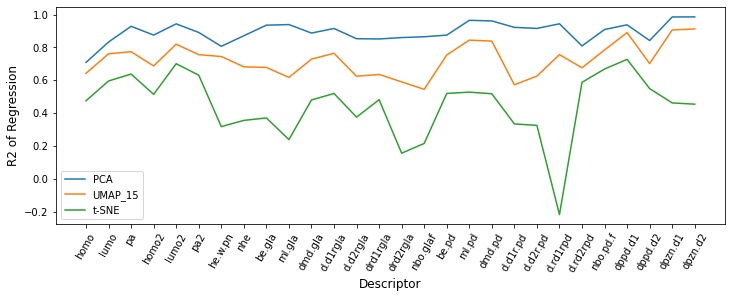

In [11]:
df_raw = plot_attribute('R2')